# Income Classification Notebook

This notebook develops a classifier to predict whether an individual's income is **greater than \$50k or not** based on demographic and employment-related attributes.  



In [2]:
# Setup and load
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split



In [3]:
# Paths
COLUMNS_PATH = "../data/census-bureau.columns"
DATA_PATH    = "../data/census-bureau.data"
MODELS_DIR   = "../models"
os.makedirs(MODELS_DIR, exist_ok=True)

In [4]:
# Load data (header + data)
with open(COLUMNS_PATH, "r") as f:
    COLS = [line.strip() for line in f if line.strip()]
df = pd.read_csv(DATA_PATH, header=None, names=COLS)

TARGET_COL = "label"
WEIGHT_COL = "weight"
RANDOM_STATE = 42

print("Shape:", df.shape)
print("Target counts:\n", df[TARGET_COL].value_counts())

Shape: (199523, 42)
Target counts:
 label
- 50000.    187141
50000+.      12382
Name: count, dtype: int64


---
## Train–Test Split


In [6]:
y = df[TARGET_COL].map({"- 50000.": 0, "50000+.": 1}).astype(int)
w = pd.to_numeric(df[WEIGHT_COL], errors="coerce").fillna(0.0)

X = df.drop(columns=[TARGET_COL])

X_train, X_valid, y_train, y_valid, w_train, w_valid = train_test_split(
    X, y, w, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train/valid shapes:", X_train.shape, X_valid.shape)
print("Positive rate train:", y_train.mean().round(3), "| valid:", y_valid.mean().round(3))


Train/valid shapes: (159618, 41) (39905, 41)
Positive rate train: 0.062 | valid: 0.062


---
## Data Cleaning

We apply straightforward preprocessing to ensure consistent datatypes.  
- Numeric columns are coerced into numeric types.  
- CPS-coded binary flags are mapped to `"Yes"`, `"No"`, or `"NIU"`.  
- Certain code columns with `0` or missing values are standardized as `"NIU"`.  
- The survey year is treated as a categorical variable.



In [8]:
def clean_data(df_):
    df = df_.copy()

    # Convert selected columns to numeric
    for c in [
        "age",
        "wage per hour",
        "capital gains",
        "capital losses",
        "dividends from stocks",
        "weeks worked in year",
        "num persons worked for employer",
        WEIGHT_COL,
    ]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Map CPS codes: 0=NIU, 1=Yes, 2=No
    code_map_yn = {0: "NIU", 1: "Yes", 2: "No"}
    for c in ["own business or self employed", "veterans benefits"]:
        if c in df.columns:
            s = pd.to_numeric(df[c], errors="coerce").astype("Int64")
            df[c] = s.map(code_map_yn).astype("string").fillna("NIU")

    # Code columns where 0 means NIU
    for c in ["detailed industry recode", "detailed occupation recode"]:
        if c in df.columns:
            s = pd.to_numeric(df[c], errors="coerce").astype("Int64")
            df[c] = s.astype("string")
            df.loc[s.eq(0) | s.isna(), c] = "NIU"

    # Map survey year to strings
    if "year" in df.columns:
        s = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
        df["year"] = s.map({94: "1994", 95: "1995"}).astype("string")

    return df

X_train_clean = clean_data(X_train)
X_valid_clean = clean_data(X_valid)

print("\nDtypes after cleaning (train):")
print(X_train_clean.dtypes.value_counts())



Dtypes after cleaning (train):
object            28
int64              7
string[python]     5
float64            1
Name: count, dtype: int64


---
## Feature Engineering

We create a small set of high-signal derived features while keeping original columns intact:  
- **Education ordinal**: map education levels into an ordered numeric scale.  
- **Monetary flags**: indicators for wages and investment-related income.  
- **Work attachment**: whether the person worked any weeks, or a full year (52 weeks).  
- **Student flag**: identify individuals currently in school.  
These engineered features capture meaningful economic and demographic signals useful for classification.


In [10]:
def add_features(df_):
    df = df_.copy()

    # Education mapped to ordinal scale
    if "education" in df.columns:
        education_order = [
            "Children",
            "Less than 1st grade",
            "1st 2nd 3rd or 4th grade",
            "5th or 6th grade",
            "7th and 8th grade",
            "9th grade",
            "10th grade",
            "11th grade",
            "12th grade no diploma",
            "High school graduate",
            "Some college but no degree",
            "Associate degree-occupational/vocational",
            "Associate degree-academic program",
            "Bachelors degree(BA AB BS)",
            "Masters degree(MA MS MEng MEd MSW MBA)",
            "Professional school degree (MD DDS DVM LLB JD)",
            "Doctorate degree(PhD EdD)",
        ]
        edu_map = {v: i for i, v in enumerate(education_order)}
        df["education_ord"] = df["education"].map(edu_map).astype("Int64")

    # Wage indicator
    if "wage per hour" in df.columns:
        df["has_wage"] = (df["wage per hour"].fillna(0) > 0)

    # Investment-related features
    if {"capital gains", "capital losses", "dividends from stocks"}.issubset(df.columns):
        cg = df["capital gains"].fillna(0)
        cl = df["capital losses"].fillna(0)
        dv = df["dividends from stocks"].fillna(0)
        df["invest_income"] = dv + cg - cl
        df["has_invest_income"] = (df["invest_income"] > 0)

    # Work attachment features
    if "weeks worked in year" in df.columns:
        wks = df["weeks worked in year"]
        df["worked_any_weeks"] = (wks.fillna(0) > 0)
        df["full_year_52w"] = (wks == 52)

    # Student indicator
    if "enroll in edu inst last wk" in df.columns:
        s = df["enroll in edu inst last wk"].astype("string")
        df["is_student"] = s.isin(["High school", "College or university"])

    return df


X_train_fe = add_features(X_train_clean)
X_valid_fe = add_features(X_valid_clean)

new_cols = sorted(set(X_train_fe.columns) - set(X_train_clean.columns))
print("New features:", new_cols)
print("Shapes:", X_train_fe.shape, X_valid_fe.shape)
print("\nDtypes after feature engineering (train):")
print(X_train_fe.dtypes.value_counts())


New features: ['education_ord', 'full_year_52w', 'has_invest_income', 'has_wage', 'invest_income', 'is_student', 'worked_any_weeks']
Shapes: (159618, 48) (39905, 48)

Dtypes after feature engineering (train):
object            28
int64              8
string[python]     5
bool               5
float64            1
Int64              1
Name: count, dtype: int64


---
## Preprocessing: Imputation, Encoding, and Scaling

We prepare the data for modeling using a `ColumnTransformer` pipeline:  

- **Numeric features**  
  - Skewed numeric variables (`wage`, `capital gains/losses`, `dividends`) are imputed, clipped at zero, log-transformed, and scaled.  
  - Certain numeric variables (`weeks worked`, `num persons worked for employer`, `education_ord`) are imputed but not scaled.  
  - Remaining numeric variables (e.g., `age`) are imputed and robustly scaled.  

- **Categorical and boolean features**  
  - Imputed with the most frequent value.  
  - Encoded with `OneHotEncoder`, dropping binary columns automatically.  

This ensures a consistent feature space for downstream models.


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

feature_cols = [c for c in X_train_fe.columns if c != WEIGHT_COL]

# Numeric vs categorical (booleans treated as categorical)
num_all = [
    c for c in feature_cols
    if pd.api.types.is_numeric_dtype(X_train_fe[c]) and not pd.api.types.is_bool_dtype(X_train_fe[c])
]
cat_cols = [c for c in feature_cols if c not in num_all]

# Split numeric features
skewed_num   = [c for c in ["wage per hour", "capital gains", "capital losses", "dividends from stocks"] if c in num_all]
no_scale_num = [c for c in ["weeks worked in year", "num persons worked for employer", "education_ord"] if c in num_all]
scaled_num   = [c for c in ["age"] if c in num_all]

remaining = [c for c in num_all if c not in skewed_num + no_scale_num + scaled_num]
scaled_num += remaining

def clip_nonneg(X):
    return np.clip(X, 0, None)

# Pipelines
skewed_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("clip", FunctionTransformer(clip_nonneg, feature_names_out="one-to-one")),
    ("log1p", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scale", RobustScaler()),
])

no_scale_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
])

scaled_num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", RobustScaler()),
])

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num_skewed", skewed_pipe, skewed_num),
        ("num_noscale", no_scale_pipe, no_scale_num),
        ("num_scaled",  scaled_num_pipe, scaled_num),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)

X_train_proc = preprocessor.fit_transform(X_train_fe[feature_cols])
X_valid_proc = preprocessor.transform(X_valid_fe[feature_cols])

print("Num (skewed):", skewed_num)
print("Num (no scale):", no_scale_num)
print("Num (scaled):", scaled_num)
print("Cat:", cat_cols)
print("\nProcessed shapes:", X_train_proc.shape, X_valid_proc.shape)


Num (skewed): ['wage per hour', 'capital gains', 'capital losses', 'dividends from stocks']
Num (no scale): ['weeks worked in year', 'num persons worked for employer', 'education_ord']
Num (scaled): ['age', 'invest_income']
Cat: ['class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business 

---
## Class Imbalance Handling

The dataset is imbalanced. We use the survey weights and adjust them so that positives (>50k) have similar total influence as negatives.  
Validation keeps original weights for fair evaluation.


In [14]:
# Compute positive/negative totals using survey weights
w_pos = float(w_train[y_train == 1].sum())
w_neg = float(w_train[y_train == 0].sum())

# Rebalance factor so positives have similar total influence
pos_factor = w_neg / max(w_pos, 1e-12)

# Training weights: survey weight * class-balance factor (only for positives)
sw_train_bal = w_train * np.where(y_train == 1, pos_factor, 1.0)

# Validation weights unchanged
sw_valid_orig = w_valid.copy()

print(f"Weighted sums  pos={w_pos:.1f}  neg={w_neg:.1f}")
print(f"pos_factor (use for training) = {pos_factor:.3f}")


Weighted sums  pos=17757764.7  neg=260051545.5
pos_factor (use for training) = 14.644


## Model training and evaluation

Train five models with sample weighting and a common evaluation routine:
- SGD Logistic
- RandomForest
- XGBoost
- LightGBM
- CatBoost

Then, separately tune the decision threshold for XGBoost and compare a count-based `scale_pos_weight`.


In [16]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    classification_report
)
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def _predict_proba_safe(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        return 1.0 / (1.0 + np.exp(-s))
    return model.predict(X).astype(float)

def eval_simple(name, model, X_val, y_val, w_val):
    p = _predict_proba_safe(model, X_val)
    roc_auc = roc_auc_score(y_val, p, sample_weight=w_val)
    pr_auc  = average_precision_score(y_val, p, sample_weight=w_val)

    # best-F1 threshold from PR
    try:
        prec, rec, thr = precision_recall_curve(y_val, p, sample_weight=w_val)
    except TypeError:
        prec, rec, thr = precision_recall_curve(y_val, p)
    f1 = (2 * prec * rec) / (prec + rec + 1e-12)
    best_idx = int(np.nanargmax(f1[1:]))
    best_thr = float(thr[best_idx])
    yhat = (p >= best_thr).astype(int)

    print(f"\n== {name} ==")
    print(f"ROC-AUC_w={roc_auc:.3f} | PR-AUC_w={pr_auc:.3f} | Thr*={best_thr:.3f}")
    print(classification_report(y_val, yhat, sample_weight=w_val, digits=3))

    fpr, tpr, _ = roc_curve(y_val, p, sample_weight=w_val)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC - {name}"); plt.legend(); plt.show()


### Fit and evaluate the five base models



== SGD Logistic (fast) ==
ROC-AUC_w=0.812 | PR-AUC_w=0.196 | Thr*=0.000
              precision    recall  f1-score   support

           0      0.985     0.807     0.887 64953101.679999925
           1      0.226     0.817     0.354 4483480.5600000145

    accuracy                          0.807 69436582.23999994
   macro avg      0.605     0.812     0.620 69436582.23999994
weighted avg      0.936     0.807     0.852 69436582.23999994



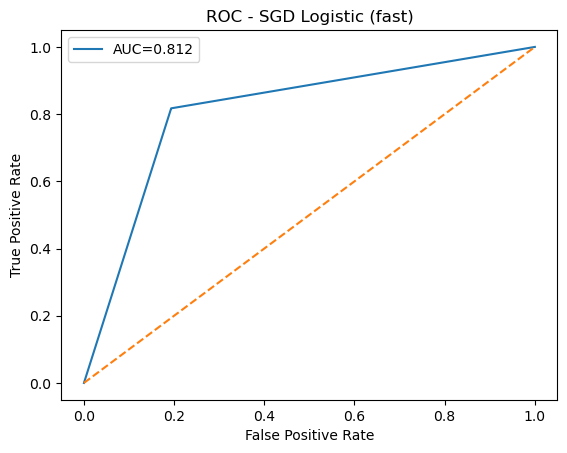

In [18]:
# 1) SGD Logistic
sgd_log = SGDClassifier(
    loss="log_loss",
    penalty="l2",
    alpha=1e-5,
    max_iter=25,
    tol=1e-3,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    learning_rate="optimal",
)
sgd_log.fit(X_train_proc, y_train, sample_weight=sw_train_bal)
eval_simple("SGD Logistic (fast)", sgd_log, X_valid_proc, y_valid, sw_valid_orig)



== RandomForest (fast) ==
ROC-AUC_w=0.941 | PR-AUC_w=0.595 | Thr*=0.720
              precision    recall  f1-score   support

           0      0.975     0.954     0.965 64953101.679999925
           1      0.494     0.647     0.560 4483480.5600000145

    accuracy                          0.934 69436582.23999994
   macro avg      0.734     0.800     0.762 69436582.23999994
weighted avg      0.944     0.934     0.938 69436582.23999994



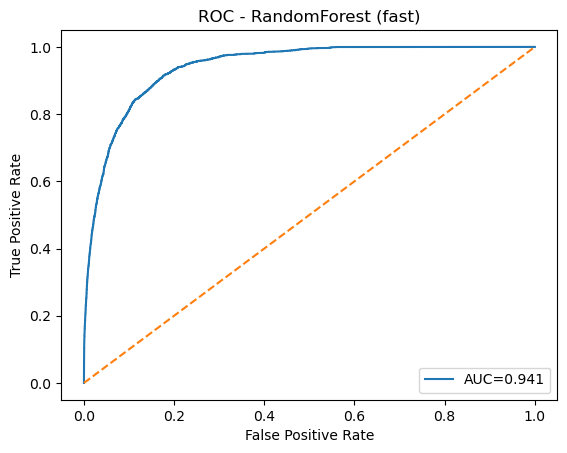

In [19]:
# 2) RandomForest - needs dense input
if sparse.issparse(X_train_proc):
    X_train_rf = X_train_proc.astype(np.float32).toarray()
    X_valid_rf = X_valid_proc.astype(np.float32).toarray()
else:
    X_train_rf = X_train_proc.astype(np.float32)
    X_valid_rf = X_valid_proc.astype(np.float32)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=5,
    max_features="sqrt",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)
rf.fit(X_train_rf, y_train, sample_weight=sw_train_bal)
eval_simple("RandomForest (fast)", rf, X_valid_rf, y_valid, sw_valid_orig)



== XGBClassifier ==
ROC-AUC_w=0.955 | PR-AUC_w=0.690 | Thr*=0.838
              precision    recall  f1-score   support

           0      0.976     0.972     0.974 64953101.679999925
           1      0.614     0.654     0.633 4483480.5600000145

    accuracy                          0.951 69436582.23999994
   macro avg      0.795     0.813     0.804 69436582.23999994
weighted avg      0.953     0.951     0.952 69436582.23999994



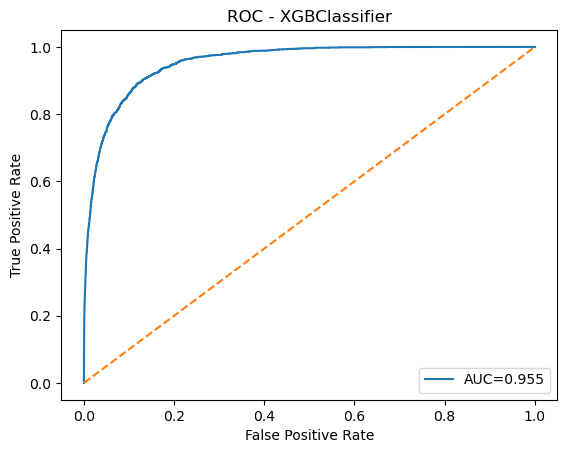

In [20]:
# 3) XGBoost - uses original weights + scale_pos_weight
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    tree_method="hist",
    eval_metric="logloss",
    scale_pos_weight=1.0,
)

# unified: pass balanced training weights everywhere
xgb.fit(X_train_proc, y_train, sample_weight=sw_train_bal)

eval_simple("XGBClassifier", xgb, X_valid_proc, y_valid, sw_valid_orig)


[LightGBM] [Info] Number of positive: 9906, number of negative: 149712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2123
[LightGBM] [Info] Number of data points in the train set: 159618, number of used features: 498
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

== LightGBM ==
ROC-AUC_w=0.955 | PR-AUC_w=0.697 | Thr*=0.817
              precision    recall  f1-score   support

           0      0.978     0.968     0.973 64953101.679999925
           1      0.595     0.678     0.633 4483480.5600000145

    accuracy                          0.949 69436582.23999994
   macro avg      0.786     0.823     0.803 69436582.23999994
weighted avg      0.953     0.949     0.951 69436582.23999994



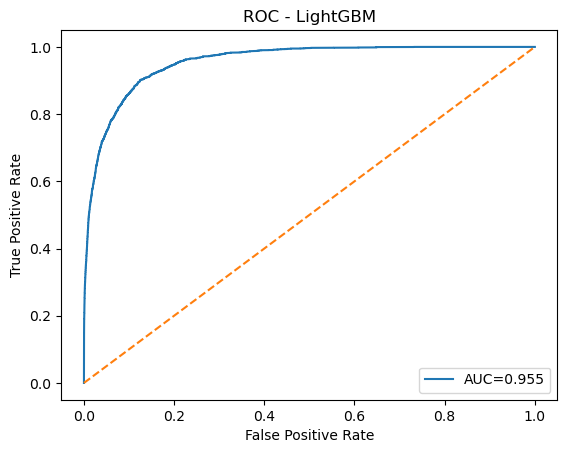

In [21]:
# 4) LightGBM
from lightgbm import LGBMClassifier


lgbm = LGBMClassifier(
    n_estimators=700,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scale_pos_weight=1.0,
)

# unified: pass balanced training weights everywhere
lgbm.fit(X_train_proc, y_train, sample_weight=sw_train_bal)
eval_simple("LightGBM", lgbm, X_valid_proc, y_valid, sw_valid_orig)


In [ ]:
# 5) CatBoost - evaluate on dense for parity with RF
from catboost import CatBoostClassifier

if sparse.issparse(X_train_proc):
    X_train_cb = X_train_proc.astype(np.float32).toarray()
    X_valid_cb = X_valid_proc.astype(np.float32).toarray()
else:
    X_train_cb = X_train_proc.astype(np.float32)
    X_valid_cb = X_valid_proc.astype(np.float32)

cat = CatBoostClassifier(
    iterations=800,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3.0,
    random_seed=RANDOM_STATE,
    loss_function="Logloss",
    eval_metric="AUC",
    verbose=False,
    thread_count=-1,
)

cat.fit(X_train_cb, y_train, sample_weight=sw_train_bal)
eval_simple("CatBoost", cat, X_valid_cb, y_valid, sw_valid_orig)


### XGBoost: threshold selection and ROC curve

Pick a probability threshold to meet a target precision on the validation set, and plot the ROC curve with AUC.


In [ ]:
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score, average_precision_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

def pick_threshold_for_precision(y, p, w, target=0.70):
    prec, rec, thr = precision_recall_curve(y, p, sample_weight=w)
    prec, rec = prec[1:], rec[1:]  # align with thr
    ok = prec >= target
    if ok.any():
        return float(thr[ok][np.argmax(rec[ok])])
    f1 = (2 * prec * rec) / (prec + rec + 1e-12)
    return float(thr[np.nanargmax(f1)])

# apply to trained XGB
p_xgb = xgb.predict_proba(X_valid_proc)[:, 1]
target_prec = 0.70
thr = pick_threshold_for_precision(y_valid, p_xgb, sw_valid_orig, target=target_prec)

yhat = (p_xgb >= thr).astype(int)
roc_auc = roc_auc_score(y_valid, p_xgb, sample_weight=sw_valid_orig)
ap = average_precision_score(y_valid, p_xgb, sample_weight=sw_valid_orig)

print(f"XGB threshold @ precision>={target_prec:.2f}: {thr:.3f}")
print(f"ROC-AUC_w={roc_auc:.3f} | AP_w={ap:.3f}")
print(classification_report(y_valid, yhat, sample_weight=sw_valid_orig, digits=3))

# ROC curve
fpr, tpr, _ = roc_curve(y_valid, p_xgb, sample_weight=sw_valid_orig)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - XGBClassifier")
plt.legend()
plt.show()


### Comparing the Results

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

models = [
    ("SGD Logistic", sgd_log, X_valid_proc),
    ("RandomForest", rf, X_valid_rf),
    ("XGBoost", xgb, X_valid_proc),
    ("LightGBM", lgbm, X_valid_proc),
    ("CatBoost", cat, X_valid_cb),
]

rows = []
plt.figure()
for name, mdl, Xv in models:
    p = _predict_proba_safe(mdl, Xv)
    rows.append({
        "model": name,
        "roc_auc_w": roc_auc_score(y_valid, p, sample_weight=sw_valid_orig),
        "ap_w": average_precision_score(y_valid, p, sample_weight=sw_valid_orig),
    })
    fpr, tpr, _ = roc_curve(y_valid, p, sample_weight=sw_valid_orig)
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC on validation")
plt.legend()
plt.show()

pd.DataFrame(rows).sort_values("ap_w", ascending=False).reset_index(drop=True)
